In [1]:
# =========================
# 0) Imports
# =========================
import os
import numpy as np
import pandas as pd

import nibabel as nib
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn import plotting

# (Optional for prettier display)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## First Level (Run level)

In [2]:

# =========================
# 1) Paths (EDIT THESE)
# =========================

# Your local working folder (where you copied the TSV)
DATA_DIR = "/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data"
events_path = os.path.join(DATA_DIR, "motif-stroke_sub-3_run-1_events.tsv")

FUNC_DIR = "/neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep/sub-03/func"
bold_path = os.path.join(FUNC_DIR, "sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
confounds_path = os.path.join(FUNC_DIR, "sub-03_task-motif4limbs_dir-ap_run-01_desc-confounds_timeseries.tsv")
mask_path = os.path.join(FUNC_DIR, "sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

for p in [events_path, bold_path, confounds_path, mask_path]:
    print(os.path.exists(p), "->", p)

True -> /volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/motif-stroke_sub-3_run-1_events.tsv
True -> /neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep/sub-03/func/sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
True -> /neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep/sub-03/func/sub-03_task-motif4limbs_dir-ap_run-01_desc-confounds_timeseries.tsv
True -> /neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep/sub-03/func/sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [3]:
# =========================
# 2) Explore the experiment TSV (stimulus timing)
# =========================
events = pd.read_csv(events_path, sep="\t")
display(events.head(10))
print("\nColumns:", list(events.columns))
print("Trial types:", events["trial_type"].unique())
print("N events:", len(events))

# fMRI convention: onsets/durations should be in seconds (not ms)
# Your TSV appears to be in milliseconds. Let's check the scale:
print("\nOnset range (raw):", events["onset"].min(), "to", events["onset"].max())
print("Duration range (raw):", events["duration"].min(), "to", events["duration"].max())

# Heuristic: if durations are ~14740, that's ms (~14.7 s).
# Convert to seconds if needed.
events_sec = events.copy()
if events_sec["duration"].median() > 50:  # crude check: seconds would be ~5-20; ms would be thousands
    events_sec["onset"] = events_sec["onset"] / 1000.0
    events_sec["duration"] = events_sec["duration"] / 1000.0
    print("\nConverted onset/duration from ms -> seconds.")

display(events_sec.head(10))

# Quick descriptive stats per condition
summary = (
    events_sec.groupby("trial_type")[["duration"]]
    .agg(["count", "mean", "std", "min", "max"])
    .round(3)
)
display(summary)


,onset,duration,trial_type
0,60944,12861.0,pied_droit
1,73805,4807.0,fix
2,78612,12861.0,pied_gauche
3,91473,4807.0,fix
4,96280,12862.0,main_gauche
5,109142,4807.0,fix
6,113949,12860.0,main_droite
7,126809,4807.0,fix
8,131616,12859.0,main_gauche
9,144475,4808.0,fix



Columns: ['onset', 'duration', 'trial_type']
Trial types: ['pied_droit' 'fix' 'pied_gauche' 'main_gauche' 'main_droite']
N events: 63

Onset range (raw): 60944 to 608649
Duration range (raw): 4807.0 to 12869.0

Converted onset/duration from ms -> seconds.


,onset,duration,trial_type
0,60.944,12.861,pied_droit
1,73.805,4.807,fix
2,78.612,12.861,pied_gauche
3,91.473,4.807,fix
4,96.280,12.862,main_gauche
5,109.142,4.807,fix
6,113.949,12.860,main_droite
7,126.809,4.807,fix
8,131.616,12.859,main_gauche
9,144.475,4.808,fix


duration                               
               count    mean    std     min     max
trial_type                                         
fix               31   4.808  0.001   4.807   4.808
main_droite        8  12.860  0.001  12.859  12.860
main_gauche        8  12.860  0.001  12.858  12.862
pied_droit         8  12.860  0.001  12.858  12.861
pied_gauche        8  12.861  0.003  12.859  12.869

In [4]:

# =========================
# 3) Load BOLD and check TR / n_scans
# =========================
img = nib.load(bold_path)
n_scans = img.shape[-1]
tr = img.header.get_zooms()[-1]  # seconds
print(f"n_scans = {n_scans}")
print(f"TR = {tr} s")

frame_times = np.arange(n_scans) * tr

# Make sure events fit inside scan duration
scan_duration = frame_times[-1] + tr
print(f"Total scan duration ~ {scan_duration:.2f} s")
print("Last event ends at:",
      float((events_sec["onset"] + events_sec["duration"]).max()),
      "s")


n_scans = 360
TR = 1.600000023841858 s
Total scan duration ~ 576.00 s
Last event ends at: 621.507 s


In [5]:
# =========================
# 4) Load confounds and select a reasonable set
# =========================
confounds = pd.read_csv(confounds_path, sep="\t")
print("Confounds columns (first 30):", list(confounds.columns)[:30])
print("Confounds shape:", confounds.shape)

# Minimal, common set:
wanted = [
    "trans_x", "trans_y", "trans_z",
    "rot_x", "rot_y", "rot_z",
    "csf", "white_matter",
    "global_signal"
]

# Keep only what exists
confounds_sel = confounds[[c for c in wanted if c in confounds.columns]].copy()

# fMRIPrep sometimes has NaNs at start; fill with 0 for GLM regressors
confounds_sel = confounds_sel.fillna(0.0)

print("Selected confounds:", list(confounds_sel.columns))
display(confounds_sel.head())


Confounds columns (first 30): ['global_signal', 'global_signal_derivative1', 'global_signal_derivative1_power2', 'global_signal_power2', 'csf', 'csf_derivative1', 'csf_power2', 'csf_derivative1_power2', 'white_matter', 'white_matter_derivative1', 'white_matter_power2', 'white_matter_derivative1_power2', 'csf_wm', 'tcompcor', 'std_dvars', 'dvars', 'framewise_displacement', 'rmsd', 't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05', 't_comp_cor_06', 'c_comp_cor_00', 'c_comp_cor_01', 'c_comp_cor_02', 'c_comp_cor_03', 'c_comp_cor_04']
Confounds shape: (360, 316)
Selected confounds: ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'csf', 'white_matter', 'global_signal']


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,csf,white_matter,global_signal
0,0.002340,-0.133351,-0.051143,-0.004797,-0.003408,-0.001266,4718.552950,5942.902411,6895.482402
1,0.014689,-0.391285,-0.356796,-0.006082,-0.004085,-0.001285,4539.217786,5870.776760,6778.800359
2,0.006280,-0.159259,-0.263012,-0.005632,-0.002719,-0.001007,4486.278295,5786.998338,6723.459732
3,0.009193,-0.265666,-0.305057,-0.006117,-0.002004,-0.000984,4699.176854,5947.567009,6944.849114
4,0.008236,-0.231139,-0.243581,-0.006650,-0.002004,-0.000985,4555.364126,5834.228764,6803.365082


Design matrix shape: (360, 26)


,fix,main_droite,main_gauche,pied_droit,pied_gauche,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,csf,white_matter,global_signal,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,drift_10,drift_11,constant
0.0,0.0,0.0,0.0,0.0,0.0,0.002340,-0.133351,-0.051143,-0.004797,-0.003408,-0.001266,4718.552950,5942.902411,6895.482402,0.074535,0.074533,0.074529,0.074524,0.074518,0.074510,0.074501,0.074490,0.074478,0.074465,0.074450,1.0
1.6,0.0,0.0,0.0,0.0,0.0,0.014689,-0.391285,-0.356796,-0.006082,-0.004085,-0.001285,4539.217786,5870.776760,6778.800359,0.074529,0.074510,0.074478,0.074433,0.074376,0.074306,0.074223,0.074127,0.074019,0.073898,0.073764,1.0
3.2,0.0,0.0,0.0,0.0,0.0,0.006280,-0.159259,-0.263012,-0.005632,-0.002719,-0.001007,4486.278295,5786.998338,6723.459732,0.074518,0.074465,0.074376,0.074252,0.074093,0.073898,0.073668,0.073403,0.073103,0.072769,0.072400,1.0
4.8,0.0,0.0,0.0,0.0,0.0,0.009193,-0.265666,-0.305057,-0.006117,-0.002004,-0.000984,4699.176854,5947.567009,6944.849114,0.074501,0.074397,0.074223,0.073980,0.073668,0.073287,0.072839,0.072322,0.071737,0.071086,0.070368,1.0
6.4,0.0,0.0,0.0,0.0,0.0,0.008236,-0.231139,-0.243581,-0.006650,-0.002004,-0.000985,4555.364126,5834.228764,6803.365082,0.074478,0.074306,0.074019,0.073618,0.073103,0.072476,0.071737,0.070888,0.069929,0.068862,0.067689,1.0


<Axes: label='conditions', ylabel='scan number'>

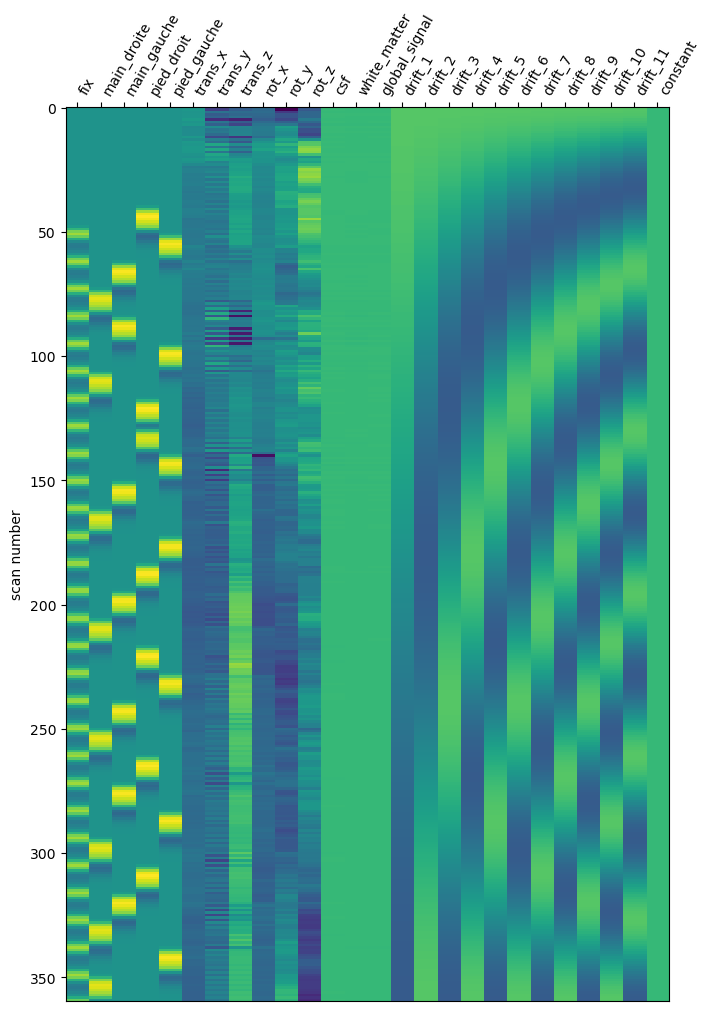

In [ ]:

# =========================
# 5) Build & display design matrix (this is X)
# =========================
dm = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events_sec,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01,
    add_regs=confounds_sel.values,
    add_reg_names=list(confounds_sel.columns),
)

print("Design matrix shape:", dm.shape)
display(dm.head())

plotting.plot_design_matrix(dm)


# cofounds are used for connectivity analyses, not for GLM. We will not include them in the design matrix for the GLM, but we will use them later when we do connectivity analyses.
# csf, white_matter, global_signal are often used as nuisance regressors in connectivity analyses, but they are not typically included in the design matrix for task-based GLM analyses. The motion
# drift regressors (cosine basis) are often included in the design matrix for GLM analyses to account for low-frequency drifts in the BOLD signal, but they are not typically used in connectivity analyses.





Task regressors found in DM: ['fix', 'main_droite', 'main_gauche', 'pied_droit', 'pied_gauche']


csf            global_signal    0.874745
white_matter   global_signal    0.856058
rot_x          drift_1          0.682878
rot_z          drift_1          0.670721
csf            white_matter     0.670251
trans_x        drift_2          0.628351
               rot_x            0.621095
               drift_1          0.570013
rot_x          rot_y            0.552369
trans_y        rot_x            0.530434
rot_x          rot_z            0.502395
rot_y          drift_2          0.405626
rot_x          drift_2          0.400473
trans_y        global_signal    0.394849
rot_y          drift_1          0.393624
trans_z        white_matter     0.386183
trans_y        white_matter     0.377250
               rot_y            0.354330
global_signal  drift_1          0.353033
trans_y        csf              0.347643
dtype: float64

<Axes: label='conditions', ylabel='scan number'>

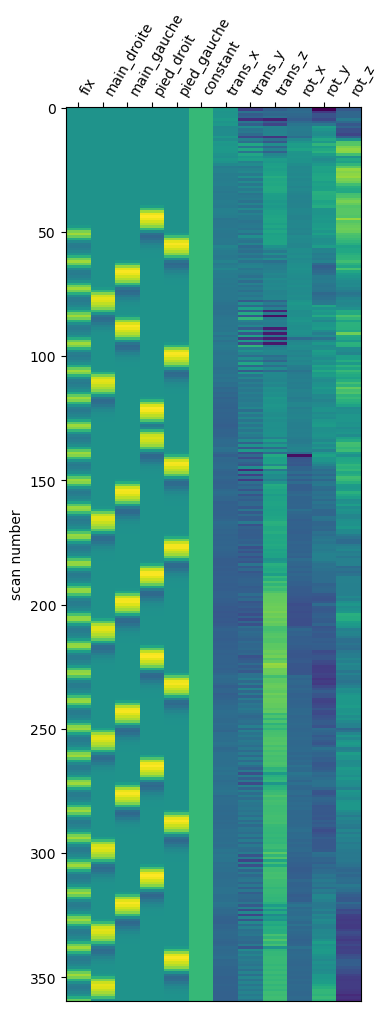

In [7]:

# =========================
# 6) Interpret / sanity checks on the design matrix
# =========================

# 6.1 Check task regressors exist
task_regs = [c for c in dm.columns if c in events_sec["trial_type"].unique()]
print("Task regressors found in DM:", task_regs)

# 6.2 Correlation check (detect collinearity)
corr = dm.corr()
# show only strong correlations (excluding self)
strong = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
display(strong.head(20))

# 6.3 Visualize a subset of regressors if too crowded
cols_to_view = task_regs + ["constant"] + [c for c in confounds_sel.columns[:6]]
plotting.plot_design_matrix(dm[cols_to_view])


In [8]:
# =========================
# 7) Fit first-level GLM
# =========================
# first_level = FirstLevelModel(
#     t_r=tr,
#     mask_img=mask_path,
#     hrf_model="glover",
#     drift_model="cosine",
#     high_pass=0.01,
#     noise_model="ar1",
#     standardize=False,
# )

flm_full = FirstLevelModel(
    t_r=tr,
    mask_img=mask_path,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01,
    noise_model="ar1",
    standardize=False,
    minimize_memory=False,   # ✅ crucial for r_square / residuals / predictions
)

first_level = flm_full.fit(run_imgs=img, design_matrices=dm)

print("GLM fitted.")



/tmp/ipykernel_112579/1178461733.py:25: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  first_level = flm_full.fit(run_imgs=img, design_matrices=dm)


GLM fitted.


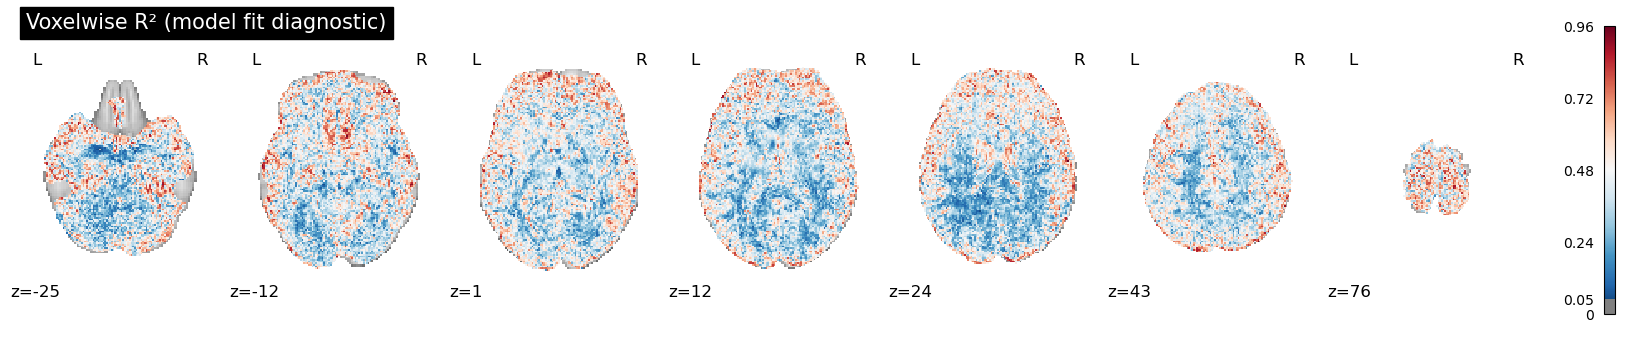

In [ ]:
# =========================
# 8) R² map (model fit diagnostic)
# =========================
from nilearn import plotting

r2_img = flm_full.r_square[0] if isinstance(flm_full.r_square, list) else flm_full.r_square

plotting.plot_stat_map(
    r2_img,
    title="Voxelwise R² (model fit diagnostic)",
    threshold=0.05,
    display_mode="z",
    cut_coords=7,
)


* z = -22  → low brain (cerebellum / brainstem area)
* z =  1   → deep structures
* z = 16   → basal ganglia / motor areas
* z = 28   → motor cortex
* z = 40   → premotor / parietal
* z = 52   → superior cortex
* z = 70   → top of the brain


FDR z-threshold: 3.0076803855328356


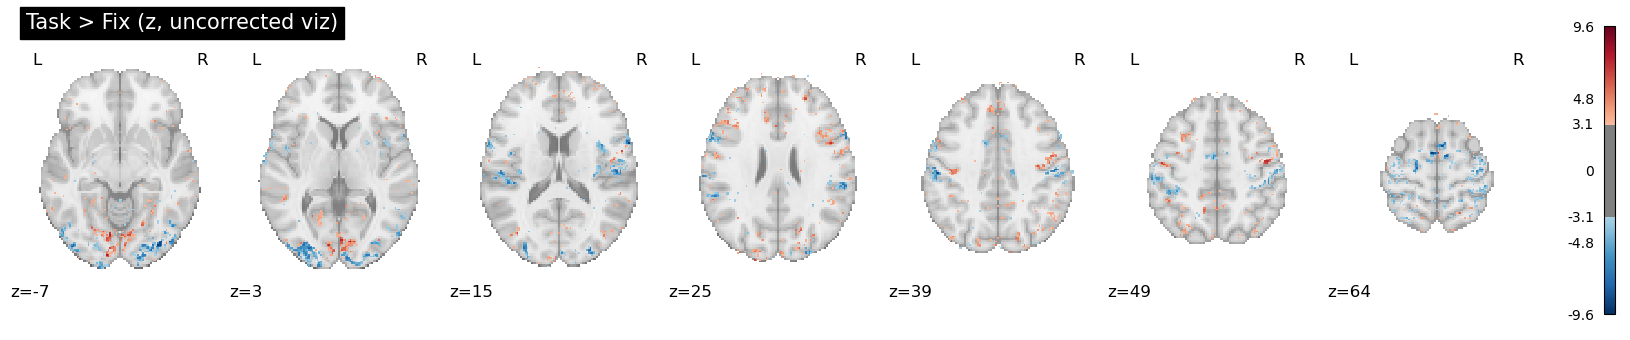

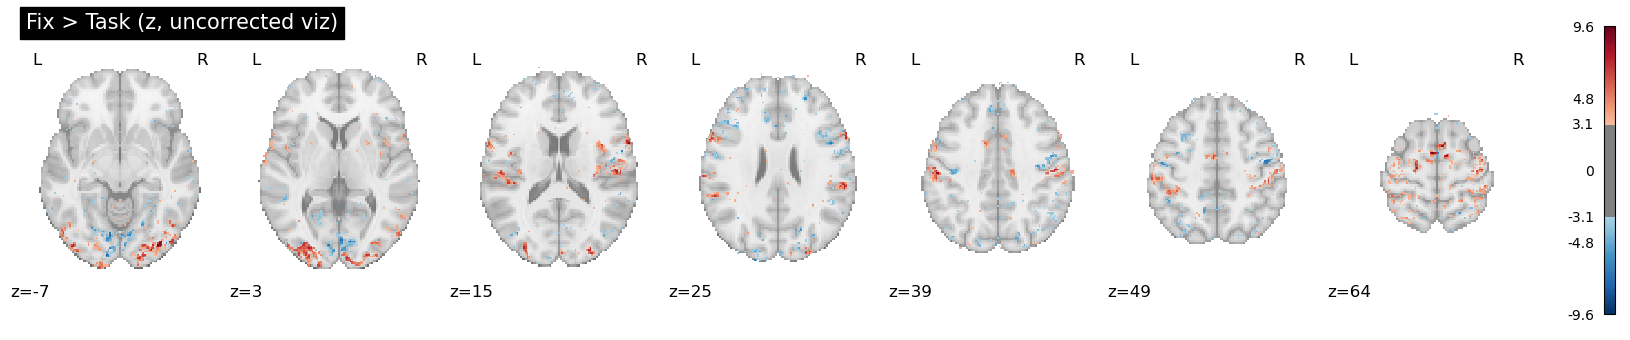

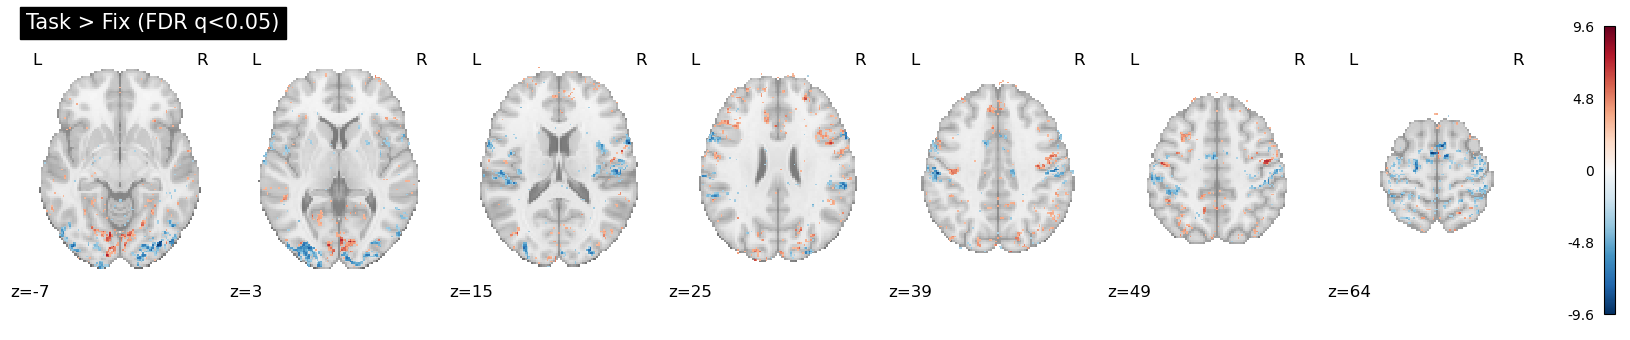

In [ ]:

# =========================
# 9) Compute contrast for Fix > Task (reverse contrast)
# =========================
# Useful to see whether fixation has consistent network activation
# (e.g., default-mode-like patterns, visual baseline effects)
# =========================

con_fix_gt_task = "fix - 0.25*(main_gauche + main_droite + pied_gauche + pied_droit)"

z_fix_gt_task = flm_full.compute_contrast(
    con_fix_gt_task,
    stat_type="t",
    output_type="z_score",
)

plotting.plot_stat_map(
    z_fix_gt_task,
    title="Fix > Task (z, uncorrected viz)",
    threshold=3.1,
    display_mode="z",
    cut_coords=7,
)

# =========================
# FDR correction for Task > Fix
# =========================
# If something survives FDR at single-subject level, that's strong evidence.
# =========================

z_thr_img, z_thr = threshold_stats_img(
    z_task_gt_fix,
    alpha=0.05,
    height_control="fdr",
)

print("FDR z-threshold:", z_thr)

plotting.plot_stat_map(
    z_thr_img,
    title="Task > Fix (FDR q<0.05)",
    display_mode="z",
    cut_coords=7,
)



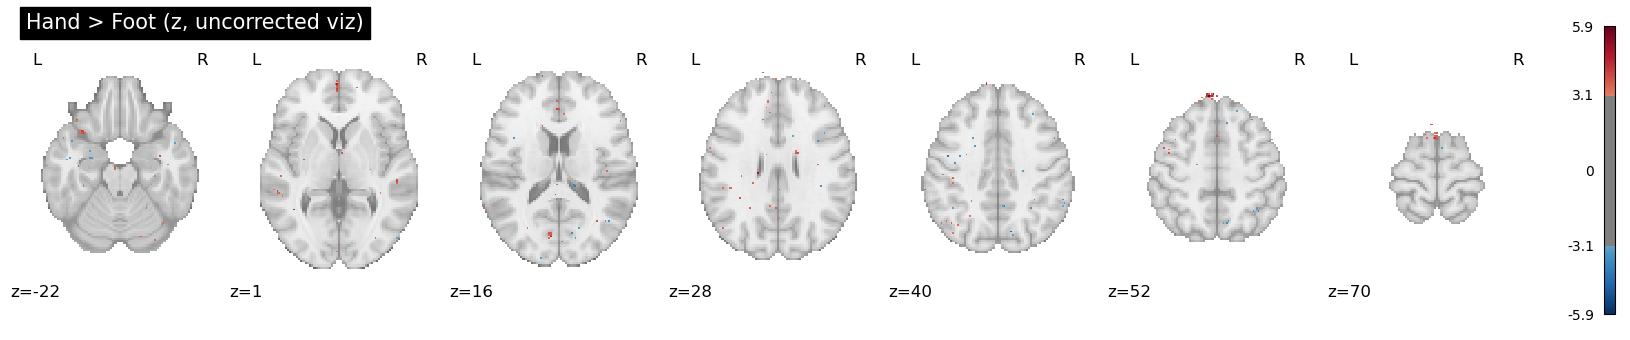

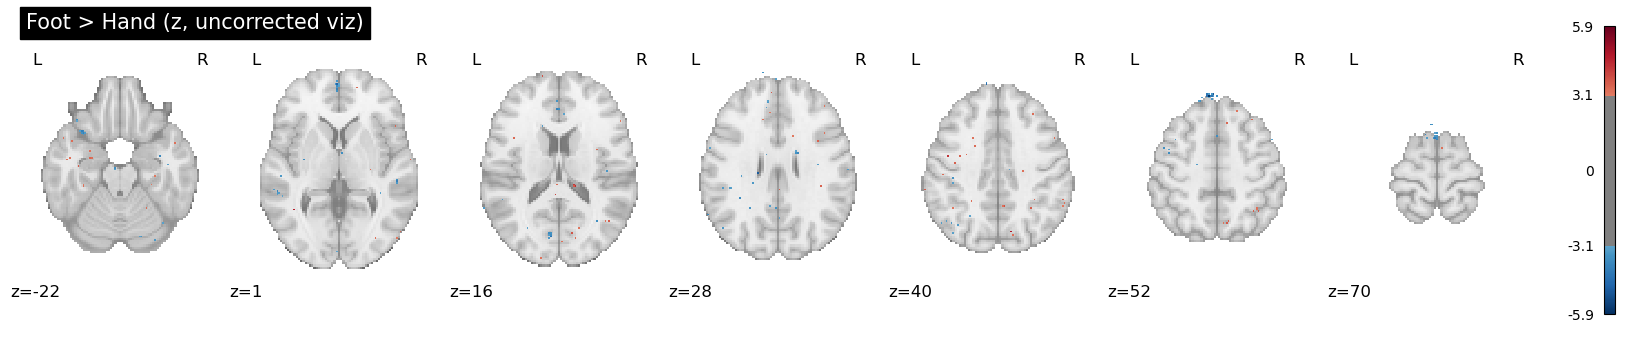

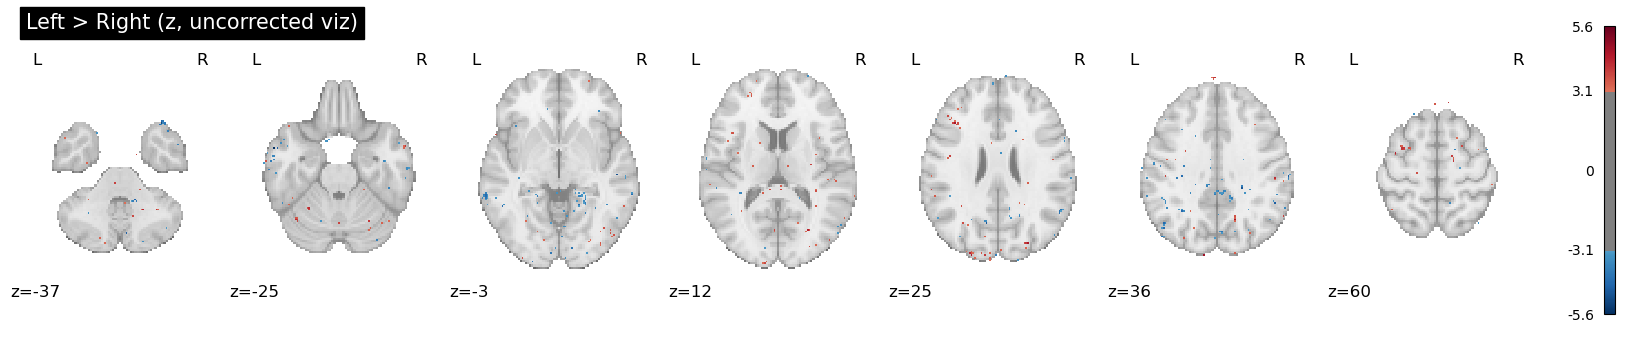

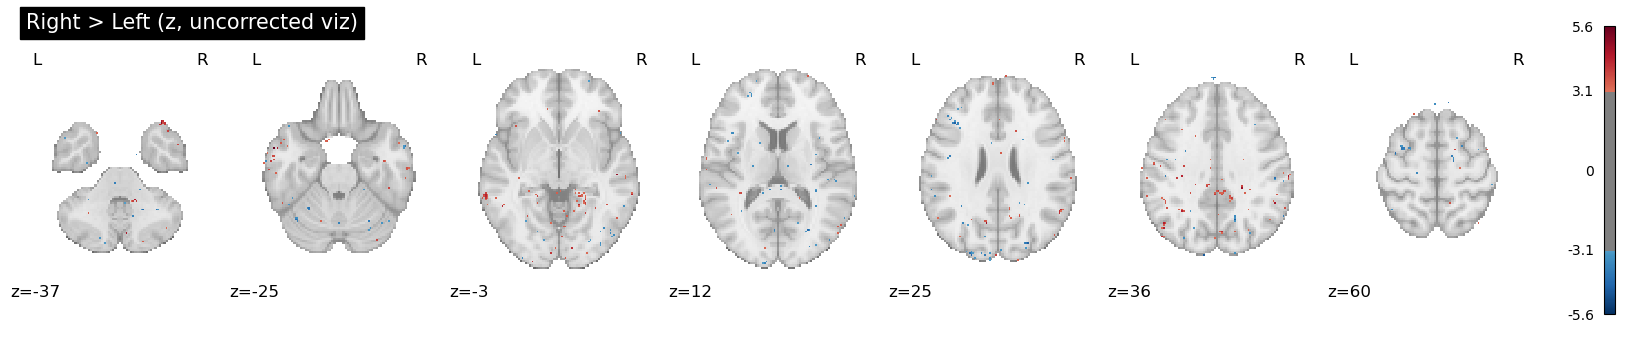

In [ ]:
# =========================
# 10) Compute motor contrasts (z-maps)
# =========================
# We compute z-score maps for easy visualization and thresholding.
# Note: these are voxelwise tests; correction is done later (FDR).
# =========================

# --- A) Hand > Foot
con_hand_gt_foot = "0.5*(main_gauche + main_droite) - 0.5*(pied_gauche + pied_droit)"
z_hand_gt_foot = flm_full.compute_contrast(con_hand_gt_foot, stat_type="t", output_type="z_score")

plotting.plot_stat_map(
    z_hand_gt_foot,
    title="Hand > Foot (z, uncorrected viz)",
    threshold=3.1,          # visualization only (roughly p~0.001 two-sided)
    display_mode="z",
    cut_coords=7,
)

# --- B) Foot > Hand
con_foot_gt_hand = "0.5*(pied_gauche + pied_droit) - 0.5*(main_gauche + main_droite)"
z_foot_gt_hand = flm_full.compute_contrast(con_foot_gt_hand, stat_type="t", output_type="z_score")

plotting.plot_stat_map(
    z_foot_gt_hand,
    title="Foot > Hand (z, uncorrected viz)",
    threshold=3.1,
    display_mode="z",
    cut_coords=7,
)

# --- C) Left > Right (all effectors)
con_left_gt_right = "0.5*(main_gauche + pied_gauche) - 0.5*(main_droite + pied_droit)"
z_left_gt_right = flm_full.compute_contrast(con_left_gt_right, stat_type="t", output_type="z_score")

plotting.plot_stat_map(
    z_left_gt_right,
    title="Left > Right (z, uncorrected viz)",
    threshold=3.1,
    display_mode="z",
    cut_coords=7,
)

# --- D) Right > Left (all effectors)
con_right_gt_left = "0.5*(main_droite + pied_droit) - 0.5*(main_gauche + pied_gauche)"
z_right_gt_left = flm_full.compute_contrast(con_right_gt_left, stat_type="t", output_type="z_score")

plotting.plot_stat_map(
    z_right_gt_left,
    title="Right > Left (z, uncorrected viz)",
    threshold=3.1,
    display_mode="z",
    cut_coords=7,
)

## Subject level

In [10]:
# =========================
# ✅ SUBJECT-LEVEL PIPELINE (Run-level GLM + optional fixed-effects across runs)
# =========================
# This notebook code does EVERYTHING needed for "subject-level" analysis:
#
# 1) Discover available preprocessed BOLD runs for sub-03 task=motif4limbs
# 2) Load the matching:
#    - BOLD (desc-preproc_bold.nii.gz)
#    - mask (desc-brain_mask.nii.gz)
#    - confounds (desc-confounds_timeseries.tsv)
#    - events TSV (motif-stroke_sub-3_run-X_events.tsv) from your local data folder
# 3) Build design matrices (events + confounds + drift + constant)
# 4) Fit a FirstLevelModel per run (voxelwise GLM)
# 5) Compute run-level contrasts (effect, variance, z)
# 6) Combine runs into a subject-level map using FIXED EFFECTS if >=2 runs
#    - If only 1 run exists, it returns the single-run map (no error)
# 7) Plot results and (optionally) save maps
#
# NOTE:
# - Fixed effects needs >= 2 runs.
# - With 1 run, "subject-level" = that run (still useful, just be honest).
# =========================

import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn import plotting


In [11]:
# =========================
# 0) PATHS + SETTINGS (EDIT THESE ONLY)
# =========================

# NeuroSpin fmriprep outputs (functional folder)
FMRIPREP_FUNC_DIR = "/neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep/sub-03/func"

# Your local folder where you placed the events TSVs for sub-03
# Must contain: motif-stroke_sub-3_run-1_events.tsv (and run-2, run-3 if exists)
EVENTS_DIR = "/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data"

SUB = "03"
TASK = "motif4limbs"
SPACE = "MNI152NLin2009cAsym"

# Confounds we want (we'll keep those present)
WANTED_CONFOUNDS = [
    "trans_x", "trans_y", "trans_z",
    "rot_x", "rot_y", "rot_z",
    "csf", "white_matter", "global_signal",
]

# GLM settings (consistent with what you did)
DRIFT_MODEL = "cosine"
HIGH_PASS = 0.01
HRF_MODEL = "glover"
NOISE_MODEL = "ar1"

print("FMRIPREP_FUNC_DIR:", FMRIPREP_FUNC_DIR)
print("EVENTS_DIR:", EVENTS_DIR)


FMRIPREP_FUNC_DIR: /neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep/sub-03/func
EVENTS_DIR: /volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data


In [12]:
# =========================
# 1) FIND ALL RUNS (BOLD FILES) FOR THIS SUBJECT/TASK
# =========================
# We look for:
# sub-03_task-motif4limbs_dir-*_run-*_space-MNI..._desc-preproc_bold.nii.gz
# =========================

bold_pattern = os.path.join(
    FMRIPREP_FUNC_DIR,
    f"sub-{SUB}_task-{TASK}_dir-*_run-*_space-{SPACE}_desc-preproc_bold.nii.gz"
)
bold_files = sorted(glob.glob(bold_pattern))

print(f"Found {len(bold_files)} BOLD files for task={TASK}")
for f in bold_files:
    print(" -", os.path.basename(f))

def parse_run_id(fname):
    base = os.path.basename(fname)
    part = [p for p in base.split("_") if p.startswith("run-")][0]  # e.g., "run-01"
    return part.split("-")[1]  # "01"

def parse_dir(fname):
    base = os.path.basename(fname)
    part = [p for p in base.split("_") if p.startswith("dir-")][0]  # e.g., "dir-ap"
    return part.split("-")[1]  # "ap"

runs = sorted(list({parse_run_id(f) for f in bold_files}))
print("Detected run IDs:", runs)


Found 2 BOLD files for task=motif4limbs
 - sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
 - sub-03_task-motif4limbs_dir-pa_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Detected run IDs: ['01', '02']


In [13]:
# =========================
# 2) LOAD EVENTS TSV FOR A GIVEN RUN
# =========================
# Your file naming (local):
# motif-stroke_sub-3_run-1_events.tsv
#
# fMRIPrep uses run-01/run-02... (with leading zeros)
# We convert "01" -> 1 to match your events naming.
# =========================

def load_events_for_run(run_id):
    run_int = int(run_id)  # "01" -> 1
    evt_path = os.path.join(EVENTS_DIR, f"motif-stroke_sub-3_run-{run_int}_events.tsv")
    if not os.path.exists(evt_path):
        raise FileNotFoundError(f"Missing events TSV for run {run_id}: {evt_path}")

    events = pd.read_csv(evt_path, sep="\t")

    # Convert ms -> seconds if needed
    # Heuristic: if onsets are large (>1000), they are in ms
    if events["onset"].max() > 1000:
        events = events.copy()
        events["onset"] = events["onset"] / 1000.0
        events["duration"] = events["duration"] / 1000.0

    return events, evt_path


In [14]:
# =========================
# 3) LOAD CONFOUNDS TSV FOR A GIVEN RUN + DIRECTION
# =========================
# Confounds are produced by fMRIPrep:
# sub-03_task-motif4limbs_dir-AP_run-01_desc-confounds_timeseries.tsv
# =========================

def load_confounds_for_run(run_id, direction):
    conf_path = os.path.join(
        FMRIPREP_FUNC_DIR,
        f"sub-{SUB}_task-{TASK}_dir-{direction}_run-{run_id}_desc-confounds_timeseries.tsv"
    )
    if not os.path.exists(conf_path):
        raise FileNotFoundError(f"Missing confounds TSV: {conf_path}")

    conf = pd.read_csv(conf_path, sep="\t")
    cols = [c for c in WANTED_CONFOUNDS if c in conf.columns]
    conf_sel = conf[cols].copy().fillna(0.0)

    return conf_sel, conf_path


In [15]:
# =========================
# 4) BUILD DESIGN MATRIX FOR A RUN
# =========================
# Design matrix = HRF-convolved task regressors + confounds + drift + constant
# =========================

def build_design_matrix(bold_img, events, confounds):
    n_scans = bold_img.shape[-1]
    tr = bold_img.header.get_zooms()[-1]
    frame_times = np.arange(n_scans) * tr

    dm = make_first_level_design_matrix(
        frame_times=frame_times,
        events=events,
        hrf_model=HRF_MODEL,
        drift_model=DRIFT_MODEL,
        high_pass=HIGH_PASS,
        add_regs=confounds.values,
        add_reg_names=list(confounds.columns),
    )
    return dm, tr, frame_times


In [17]:
# =========================
# 5) DEFINE CONTRASTS (HYPOTHESES)
# =========================
# These contrasts match your experiment:
# - Task > Fix (sanity check)
# - Hand > Foot (motor topography)
# =========================

CONTRASTS = {
    "task_gt_fix": "0.25*(main_gauche + main_droite + pied_gauche + pied_droit) - fix",
    "hand_gt_foot": "0.5*(main_gauche + main_droite) - 0.5*(pied_gauche + pied_droit)",
}


In [18]:
# =========================
# 6) RUN-LEVEL GLM FOR EACH RUN
# =========================
# We will store, per run:
# - design matrix
# - fitted FirstLevelModel
# - contrast images: effect, variance, z
# =========================

run_results = {}

for bold_path in bold_files:
    run_id = parse_run_id(bold_path)
    direction = parse_dir(bold_path)

    print("\n=====================")
    print(f"RUN {run_id} | dir={direction}")
    print("BOLD:", os.path.basename(bold_path))

    # 6.1 Load BOLD image
    bold_img = nib.load(bold_path)

    # 6.2 Load mask
    mask_path = os.path.join(
        FMRIPREP_FUNC_DIR,
        f"sub-{SUB}_task-{TASK}_dir-{direction}_run-{run_id}_space-{SPACE}_desc-brain_mask.nii.gz"
    )
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Missing mask: {mask_path}")

    # 6.3 Load events + confounds
    events, evt_path = load_events_for_run(run_id)
    confounds, conf_path = load_confounds_for_run(run_id, direction)

    # 6.4 Build design matrix
    dm, tr, frame_times = build_design_matrix(bold_img, events, confounds)

    print("TR:", tr, "| n_scans:", bold_img.shape[-1], "| DM shape:", dm.shape)
    print("Events:", os.path.basename(evt_path))
    print("Confounds selected:", list(confounds.columns))
    print("Task columns present:", [c for c in ["fix","main_gauche","main_droite","pied_gauche","pied_droit"] if c in dm.columns])

    # 6.5 Fit GLM (voxelwise)
    flm_run = FirstLevelModel(
        t_r=tr,
        mask_img=mask_path,
        hrf_model=HRF_MODEL,
        drift_model=DRIFT_MODEL,
        high_pass=HIGH_PASS,
        noise_model=NOISE_MODEL,
        standardize=False,
        minimize_memory=True,
    ).fit(bold_img, design_matrices=dm)

    # 6.6 Compute contrasts (effect, variance, z)
    contrasts_out = {}
    for cname, cexpr in CONTRASTS.items():
        eff = flm_run.compute_contrast(cexpr, stat_type="t", output_type="effect_size")
        var = flm_run.compute_contrast(cexpr, stat_type="t", output_type="effect_variance")
        zmap = flm_run.compute_contrast(cexpr, stat_type="t", output_type="z_score")

        contrasts_out[cname] = {"effect": eff, "variance": var, "z": zmap}

    run_results[(run_id, direction)] = {
        "run_id": run_id,
        "direction": direction,
        "bold_path": bold_path,
        "mask_path": mask_path,
        "events_path": evt_path,
        "confounds_path": conf_path,
        "dm": dm,
        "flm": flm_run,
        "contrasts": contrasts_out,
    }

print("\n✅ Finished run-level GLMs:", len(run_results))



RUN 01 | dir=ap
BOLD: sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
TR: 1.6 | n_scans: 360 | DM shape: (360, 26)
Events: motif-stroke_sub-3_run-1_events.tsv
Confounds selected: ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'csf', 'white_matter', 'global_signal']
Task columns present: ['fix', 'main_gauche', 'main_droite', 'pied_gauche', 'pied_droit']


/tmp/ipykernel_128739/1256919015.py:44: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm_run = FirstLevelModel(



RUN 02 | dir=pa
BOLD: sub-03_task-motif4limbs_dir-pa_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
TR: 1.6 | n_scans: 360 | DM shape: (360, 26)
Events: motif-stroke_sub-3_run-2_events.tsv
Confounds selected: ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'csf', 'white_matter', 'global_signal']
Task columns present: ['fix', 'main_gauche', 'main_droite', 'pied_gauche', 'pied_droit']


/tmp/ipykernel_128739/1256919015.py:44: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm_run = FirstLevelModel(



✅ Finished run-level GLMs: 2


In [20]:
# =========================
# ✅ Subject-level fixed effects (robust to Nilearn versions)
# =========================
# Some Nilearn versions return:
# - (effect, variance)
# Others return:
# - (effect, variance, z)
# Or:
# - (effect, variance, t, z)
# So we capture everything and pick what we need.
# =========================

from nilearn.glm.contrasts import compute_fixed_effects

def subject_level_for_contrast(cname):
    effect_imgs = []
    variance_imgs = []
    z_imgs = []
    run_keys = []

    for key, res in run_results.items():
        effect_imgs.append(res["contrasts"][cname]["effect"])
        variance_imgs.append(res["contrasts"][cname]["variance"])
        z_imgs.append(res["contrasts"][cname]["z"])
        run_keys.append(key)

    # ---- Case 1: only one run -> "subject-level" == run-level
    if len(effect_imgs) < 2:
        return {
            "effect": effect_imgs[0],
            "variance": variance_imgs[0],
            "z": z_imgs[0],
            "mode": "single_run",
            "runs": run_keys,
        }

    # ---- Case 2: >= 2 runs -> fixed effects
    out = compute_fixed_effects(effect_imgs, variance_imgs)

    # out can be length 2, 3, or 4 depending on nilearn version
    if not isinstance(out, (tuple, list)):
        raise TypeError(f"Unexpected output type from compute_fixed_effects: {type(out)}")

    if len(out) == 2:
        subj_eff, subj_var = out
        subj_z = None
        subj_t = None
    elif len(out) == 3:
        subj_eff, subj_var, subj_z = out
        subj_t = None
    elif len(out) == 4:
        subj_eff, subj_var, subj_t, subj_z = out
    else:
        raise ValueError(f"Unexpected number of outputs from compute_fixed_effects: {len(out)}")

    # Prefer z if available, otherwise fall back to t if available, otherwise effect
    display_img = subj_z if subj_z is not None else (subj_t if subj_t is not None else subj_eff)

    return {
        "effect": subj_eff,
        "variance": subj_var,
        "t": subj_t,
        "z": subj_z,
        "display": display_img,
        "mode": "fixed_effects",
        "runs": run_keys,
        "n_outputs": len(out),
    }



Contrast: task_gt_fix
Subject-level mode: fixed_effects
Runs used: [('01', 'ap'), ('02', 'pa')]
compute_fixed_effects outputs: 4

Contrast: hand_gt_foot
Subject-level mode: fixed_effects
Runs used: [('01', 'ap'), ('02', 'pa')]
compute_fixed_effects outputs: 4

✅ Subject-level maps ready.


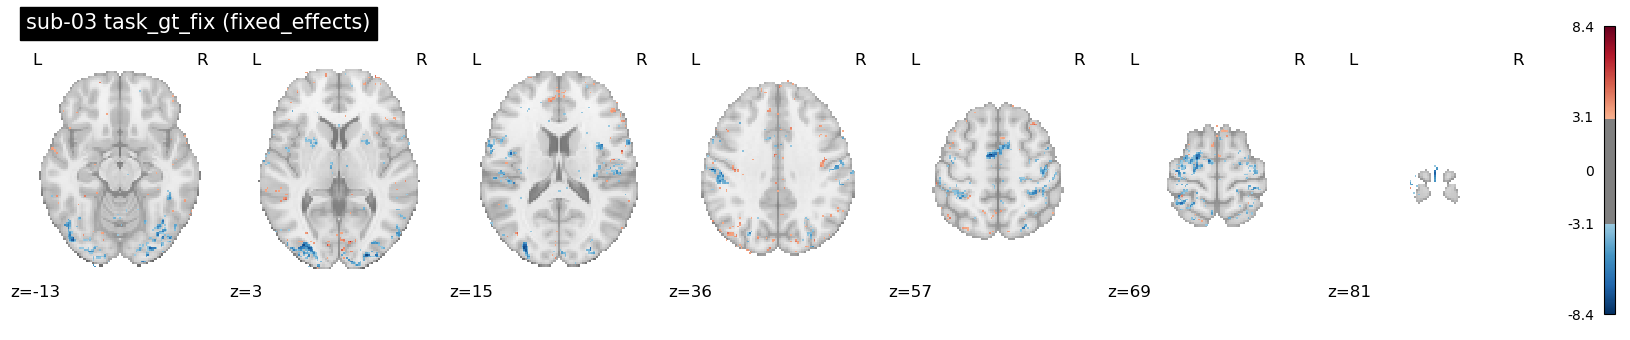

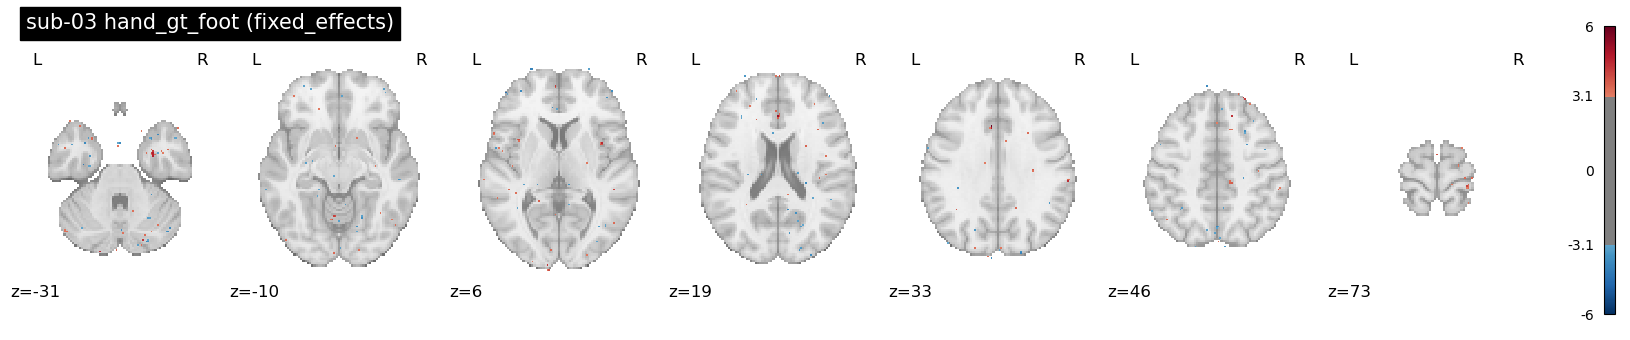

In [21]:
# =========================
# ✅ Compute + plot subject-level maps
# =========================

subj_maps = {}

for cname in CONTRASTS.keys():
    subj_maps[cname] = subject_level_for_contrast(cname)

    print("\n=====================")
    print("Contrast:", cname)
    print("Subject-level mode:", subj_maps[cname]["mode"])
    print("Runs used:", subj_maps[cname]["runs"])
    if subj_maps[cname]["mode"] == "fixed_effects":
        print("compute_fixed_effects outputs:", subj_maps[cname]["n_outputs"])

    plotting.plot_stat_map(
        subj_maps[cname]["display"],
        title=f"sub-{SUB} {cname} ({subj_maps[cname]['mode']})",
        threshold=3.1,
        display_mode="z",
        cut_coords=7,
    )

print("\n✅ Subject-level maps ready.")
